In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error


data_dir = 'data/'

ratings_train = np.load(os.path.join(data_dir, 'ratings_train.npy'))
ratings_test = np.load(os.path.join(data_dir, 'ratings_test.npy'))
names_and_genres = np.load(os.path.join(data_dir, 'namesngenre.npy'))


# # Concat the train and test data and then split them again 90% train and 10% test
# ratings = np.concatenate((ratings_train, ratings_test), axis=0)
# np.random.shuffle(ratings)
# split_index = int(0.9 * ratings.shape[0])

# ratings_train = ratings[:split_index]
# ratings_test = ratings[split_index:]

print(ratings_train.shape)
print(ratings_test.shape)
print(names_and_genres.shape)

/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(610, 4980)
(610, 4980)
(4980, 2)


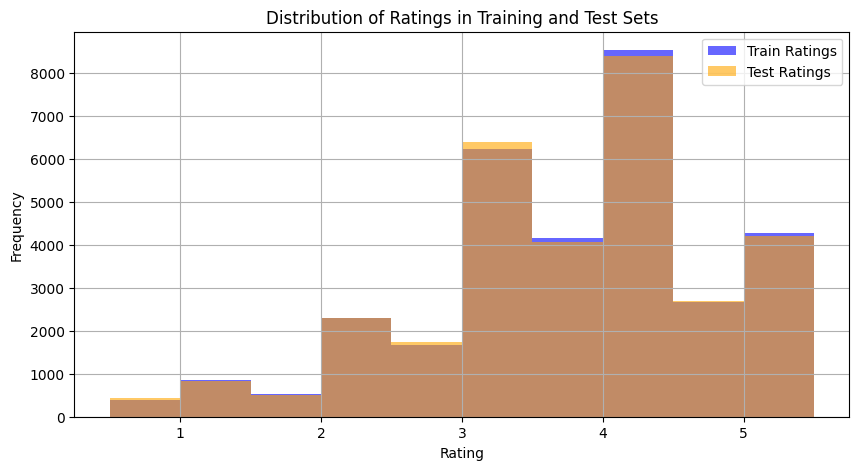

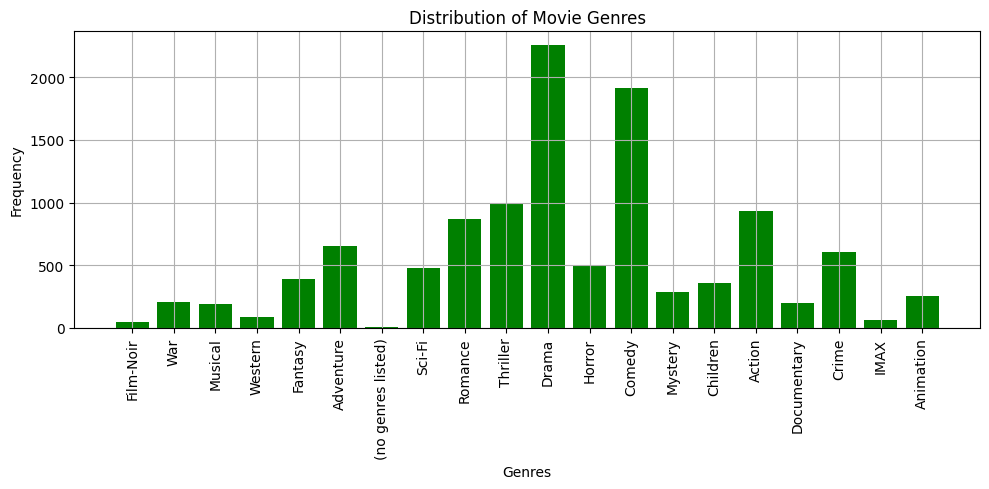

(0.9895983935742972,
 0.9895983935742972,
 {'Film-Noir': 50,
  'War': 203,
  'Musical': 188,
  'Western': 88,
  'Fantasy': 388,
  'Adventure': 651,
  '(no genres listed)': 8,
  'Sci-Fi': 476,
  'Romance': 871,
  'Thriller': 991,
  'Drama': 2253,
  'Horror': 493,
  'Comedy': 1916,
  'Mystery': 283,
  'Children': 358,
  'Action': 931,
  'Documentary': 196,
  'Crime': 606,
  'IMAX': 66,
  'Animation': 257})

In [3]:
# Function to calculate sparsity of the matrix
def calculate_sparsity(matrix):
    total_elements = matrix.size
    non_nan_elements = np.count_nonzero(~np.isnan(matrix))
    sparsity = (total_elements - non_nan_elements) / total_elements
    return sparsity

# Calculate sparsity for train and test data
train_sparsity = calculate_sparsity(ratings_train)
test_sparsity = calculate_sparsity(ratings_test)

# Calculate the distribution of ratings in the training data (excluding NaN values)
train_ratings = ratings_train[~np.isnan(ratings_train)]
test_ratings = ratings_test[~np.isnan(ratings_test)]

# Plot the distribution of ratings
plt.figure(figsize=(10, 5))
plt.hist(train_ratings, bins=np.arange(0.5, 6, 0.5), alpha=0.6, color='blue', label='Train Ratings')
plt.hist(test_ratings, bins=np.arange(0.5, 6, 0.5), alpha=0.6, color='orange', label='Test Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings in Training and Test Sets')
plt.legend()
plt.grid(True)
plt.show()

# Generate insights from the genre data
unique_genres = set()
for item in names_and_genres[:, 1]:
    genres = item.split('|')
    unique_genres.update(genres)

# Count the occurrence of each genre
genre_counts = {genre: 0 for genre in unique_genres}
for item in names_and_genres[:, 1]:
    genres = item.split('|')
    for genre in genres:
        genre_counts[genre] += 1

# Plot genre distribution
plt.figure(figsize=(10, 5))
plt.bar(genre_counts.keys(), genre_counts.values(), color='green')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Genres')
plt.grid(True)
plt.tight_layout()
plt.show()

(train_sparsity, test_sparsity, genre_counts)

In [40]:
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares


# Replace NaN with zeros for the ALS model
ratings_train_filled = np.nan_to_num(ratings_train)

# Create a sparse matrix from the training data
train_sparse_matrix = coo_matrix(ratings_train_filled)

# Initialize ALS model
als_model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=15)

# Train the ALS model
als_model.fit(train_sparse_matrix)

# Compute the full user-item rating matrix
user_factors = als_model.user_factors
item_factors = als_model.item_factors

# Full predicted ratings matrix
predicted_ratings = np.dot(user_factors, item_factors.T)

# Replace known ratings with NaN to focus on predicting the unknown ratings
predicted_ratings[~np.isnan(ratings_train)] = np.nan

# Ensure the predicted ratings matrix has the same shape as the test matrix
assert predicted_ratings.shape == ratings_test.shape

# Now, you can use the `predicted_ratings` to fill in the missing values in the test set
print(predicted_ratings[:5])  # Show first 5 users' predictions


/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00022125244140625 seconds
  warnings.warn(
100%|██████████| 15/15 [00:00<00:00, 48.71it/s]


[[        nan  0.2262024   0.09547327 ...  0.01369371 -0.00271829
  -0.00723346]
 [ 0.1544781  -0.02664817  0.0234977  ...  0.03892128 -0.00480416
   0.01223741]
 [-0.0084993   0.00147254  0.00951974 ... -0.00076467 -0.00272354
   0.00152909]
 [ 0.54744637 -0.13786674  0.0686382  ...  0.07062963 -0.00134135
   0.04076454]
 [ 0.3895667   0.41710284  0.12604138 ...  0.01174673  0.00228027
  -0.00615845]]


In [41]:
# Count nan values in the predicted ratings
num_nan_values = np.isnan(predicted_ratings).sum()
num_nan_values

31598

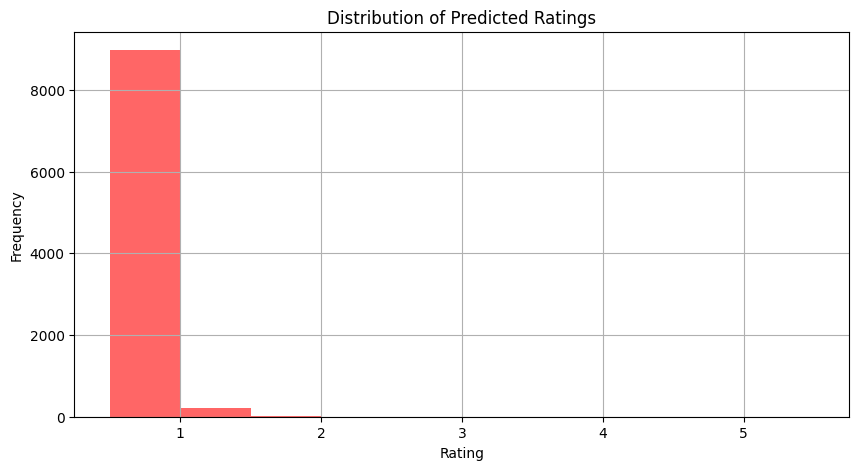

In [45]:
# Plot the distribution of predicted ratings
predicted_ratings = predicted_ratings[~np.isnan(predicted_ratings)]
plt.figure(figsize=(10, 5))
plt.hist(predicted_ratings, bins=np.arange(0.5, 6, 0.5), color='red', alpha=0.6)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Ratings')
plt.grid(True)
plt.show()


In [33]:
# import numpy as np
# from scipy.sparse import coo_matrix
# from implicit.als import AlternatingLeastSquares
# from sklearn.metrics import mean_squared_error
# import optuna

# # Define the objective function for Optuna
# def objective(trial):
#     # Suggest values for hyperparameters (factors, regularization, and iterations)
#     factors = trial.suggest_int('factors', 10, 100)
#     regularization = trial.suggest_loguniform('regularization', 1e-3, 1e0)
#     iterations = trial.suggest_int('iterations', 100, 3000)
    
#     # Create a mask for known values in the training set
#     train_mask = ~np.isnan(ratings_train)
    
#     # Build a sparse matrix from the known values (ignoring NaN values)
#     row_indices, col_indices = np.where(train_mask)
#     data = ratings_train[train_mask]
#     train_sparse_matrix = coo_matrix((data, (row_indices, col_indices)), shape=ratings_train.shape)

#     # Initialize ALS model with the suggested hyperparameters
#     als_model = AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)

#     # Train the ALS model on the sparse matrix
#     als_model.fit(train_sparse_matrix)

#     # Get the user and item factors after training
#     user_factors = als_model.user_factors
#     item_factors = als_model.item_factors

#     # Generate the full predicted ratings matrix using the dot product of user and item factors
#     predicted_ratings = np.dot(user_factors, item_factors.T)

#     # Apply min-max scaling to the predicted ratings
#     min_val, max_val = np.min(predicted_ratings), np.max(predicted_ratings)
#     scaled_predictions = 0.5 + (predicted_ratings - min_val) * (5 - 0.5) / (max_val - min_val)

#     # Clip the scaled predictions to ensure they stay within [0.5, 5]
#     scaled_predictions_clipped = np.clip(scaled_predictions, 0.5, 5)

#     # Extract non-NaN values from the test set and corresponding predictions
#     test_mask = ~np.isnan(ratings_test)
#     actual_test_ratings = ratings_test[test_mask]
#     predicted_test_ratings = scaled_predictions_clipped[test_mask]

#     # Calculate RMSE to compare predicted values with actual values in the test set
#     rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))

#     return rmse

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # You can set the number of trials

# # Print the best hyperparameters
# print(f"Best hyperparameters: {study.best_params}")
# print(f"Best RMSE: {study.best_value}")


[I 2024-09-25 16:55:29,418] A new study created in memory with name: no-name-2d3f1c19-aebd-4e97-8aca-fb2ea8e2a2c0
/tmp/ipykernel_11483/1276292016.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 1e-3, 1e0)
/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0013165473937988281 seconds
  warnings.warn(
100%|██████████| 1818/1818 [00:34<00:00, 53.44it/s]
[I 2024-09-25 16:56:03,561] Trial 0 finished with value: 1.2530858808026357 and parameters: {'factors': 45, 'regularization': 0.024173277624712115, 'iterations': 1818}. Best is trial 0 with value: 1.2530858808026357.
/tmp/ipykernel_11483/1276292016.py:11: FutureWarning: suggest_lo

Best hyperparameters: {'factors': 10, 'regularization': 0.15091452252867013, 'iterations': 615}
Best RMSE: 1.1122436568635479


In [34]:
# import numpy as np
# from scipy.sparse import coo_matrix
# from implicit.als import AlternatingLeastSquares
# from sklearn.metrics import mean_squared_error
# import optuna

# # Define the objective function for Optuna
# def objective(trial):
#     # Suggest values for hyperparameters (factors, regularization, and iterations)
#     factors = trial.suggest_int('factors', 1, 10)
#     regularization = trial.suggest_loguniform('regularization', 1e-3, 1e0)
#     iterations = trial.suggest_int('iterations', 100, 3000)
    
#     # Create a mask for known values in the training set
#     train_mask = ~np.isnan(ratings_train)
    
#     # Build a sparse matrix from the known values (ignoring NaN values)
#     row_indices, col_indices = np.where(train_mask)
#     data = ratings_train[train_mask]
#     train_sparse_matrix = coo_matrix((data, (row_indices, col_indices)), shape=ratings_train.shape)

#     # Initialize ALS model with the suggested hyperparameters
#     als_model = AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)

#     # Train the ALS model on the sparse matrix
#     als_model.fit(train_sparse_matrix)

#     # Get the user and item factors after training
#     user_factors = als_model.user_factors
#     item_factors = als_model.item_factors

#     # Generate the full predicted ratings matrix using the dot product of user and item factors
#     predicted_ratings = np.dot(user_factors, item_factors.T)

#     # Apply min-max scaling to the predicted ratings
#     min_val, max_val = np.min(predicted_ratings), np.max(predicted_ratings)
#     scaled_predictions = 0.5 + (predicted_ratings - min_val) * (5 - 0.5) / (max_val - min_val)

#     # Clip the scaled predictions to ensure they stay within [0.5, 5]
#     scaled_predictions_clipped = np.clip(scaled_predictions, 0.5, 5)

#     # Extract non-NaN values from the test set and corresponding predictions
#     test_mask = ~np.isnan(ratings_test)
#     actual_test_ratings = ratings_test[test_mask]
#     predicted_test_ratings = scaled_predictions_clipped[test_mask]

#     # Calculate RMSE to compare predicted values with actual values in the test set
#     rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))

#     return rmse

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # You can set the number of trials

# # Print the best hyperparameters
# print(f"Best hyperparameters: {study.best_params}")
# print(f"Best RMSE: {study.best_value}")


[I 2024-09-25 17:18:28,094] A new study created in memory with name: no-name-7d2fa924-88df-4a6b-9ed3-184c5e73e312
/tmp/ipykernel_11483/3377512858.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 1e-3, 1e0)
/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00036597251892089844 seconds
  warnings.warn(
100%|██████████| 2147/2147 [00:31<00:00, 67.76it/s]
[I 2024-09-25 17:18:59,855] Trial 0 finished with value: 1.0630256445834434 and parameters: {'factors': 3, 'regularization': 0.0248499875360242, 'iterations': 2147}. Best is trial 0 with value: 1.0630256445834434.
/tmp/ipykernel_11483/3377512858.py:11: FutureWarning: suggest_logu

Best hyperparameters: {'factors': 4, 'regularization': 0.006501003905871741, 'iterations': 138}
Best RMSE: 1.0291047346762194


In [4]:
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error


# Create a mask for known values in the training set
train_mask = ~np.isnan(ratings_train)

# Build a sparse matrix from the known values (ignoring NaN values)
row_indices, col_indices = np.where(train_mask)
data = ratings_train[train_mask]
train_sparse_matrix = coo_matrix((data, (row_indices, col_indices)), shape=ratings_train.shape)

# Initialize ALS model (tune the parameters as needed)
# {'factors': 10, 'regularization': 0.15091452252867013, 'iterations': 615}
als_model = AlternatingLeastSquares(factors=10, regularization=0.15091452252867013, iterations=615)
# als_model = AlternatingLeastSquares(factors=4, regularization=0.006501003905871741, iterations=138)

# Train the ALS model on the sparse matrix
als_model.fit(train_sparse_matrix)

# Get the user and item factors after training
user_factors = als_model.user_factors
item_factors = als_model.item_factors

# Generate the full predicted ratings matrix using the dot product of user and item factors
predicted_ratings = np.dot(user_factors, item_factors.T)

# Apply min-max scaling to the predicted ratings
min_val, max_val = np.min(predicted_ratings), np.max(predicted_ratings)
scaled_predictions = 0.5 + (predicted_ratings - min_val) * (5 - 0.5) / (max_val - min_val)

# Clip the scaled predictions to ensure they stay within [0.5, 5]
scaled_predictions_clipped = np.clip(scaled_predictions, 0.5, 5)

# Fill in the missing values in the test set (i.e., where test set has NaN values)
filled_test_set = np.copy(ratings_test)
nan_mask = np.isnan(filled_test_set)
filled_test_set[nan_mask] = scaled_predictions_clipped[nan_mask]

# Extract non-NaN values from the test set and corresponding predictions
test_mask = ~np.isnan(ratings_test)
actual_test_ratings = ratings_test[test_mask]
predicted_test_ratings = scaled_predictions_clipped[test_mask]

# Calculate RMSE to compare predicted values with actual values in the test set
rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))
print(f"RMSE between predicted and actual test ratings: {rmse}")

# Calculate accuracy (percentage of exact matches)
exact_matches = np.sum(np.isclose(predicted_test_ratings, actual_test_ratings, atol=0.25))  # Allow small tolerance
total_ratings = len(actual_test_ratings)
accuracy = exact_matches / total_ratings * 100

print(f"Accuracy (exact matches): {accuracy:.2f}%")


/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002233743667602539 seconds
  warnings.warn(
100%|██████████| 615/615 [00:10<00:00, 58.52it/s]


RMSE between predicted and actual test ratings: 1.1122426774515735
Accuracy (exact matches): 18.99%


In [8]:
# Take the predictions and round to the nearest 0.5
# *2 because round only works with integers and then /2 to get back to the original scale
scaled_predictions_clipped_rounded = (np.round(scaled_predictions_clipped * 2) / 2) + 0.5 

# Calculate RMSE to compare predicted values with actual values in the test set
rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))
rmse_rounded = np.sqrt(mean_squared_error(actual_test_ratings, scaled_predictions_clipped_rounded[test_mask]))

print(f"RMSE before rounding: {rmse}\nRMSE after rounding predictions: {rmse_rounded}")

RMSE before rounding: 1.1122426774515735
RMSE after rounding predictions: 1.0400662326088557


In [50]:
# Print the predicted ratings for the first user against the true ratings in the test set
user_id = 56
user_ratings = ratings_test[user_id]
predicted_user_ratings = scaled_predictions_clipped[user_id]
predicted_user_ratings_rounded = scaled_predictions_clipped_rounded[user_id]

# Print the training ratings for the first user (excluding NaN values)
print("Training Ratings:")
print(ratings_train[user_id][~np.isnan(ratings_train[user_id])])



# Create a mask for known values in the test set
known_mask = ~np.isnan(user_ratings)

# Print the true and predicted ratings for the first user
print("True Ratings:")
print(user_ratings[known_mask])
print("\nPredicted Ratings:")
print(predicted_user_ratings[known_mask])
print("\nPredicted Ratings (Rounded):")
print(predicted_user_ratings_rounded[known_mask])


Training Ratings:
[3. 4. 1. 4. 1. 3. 2. 4. 4. 1. 1. 3. 3. 4. 1. 4. 2. 3. 5. 3. 3. 4. 4. 4.
 5. 4. 4. 2. 2. 2. 4. 3. 2. 3. 4. 5. 5. 4. 4. 4. 4. 2. 1. 4. 4. 3. 4. 5.
 5. 3. 4. 4. 5. 4. 5. 5. 5. 3. 4. 5. 2. 4. 2. 3. 2. 2. 3. 3. 2. 3. 4. 4.
 2. 5. 2. 4. 4. 3. 2. 3. 2. 2. 2. 3. 3. 2. 4. 4. 5. 5. 4. 3. 1. 4. 3. 3.
 5. 3. 2. 4. 5. 3. 4. 2. 5. 2. 3. 1. 3. 3. 3. 3. 3. 4. 3. 1. 4. 4. 4. 4.
 4. 5. 4. 3. 4. 4. 3. 3. 3. 4. 5. 4. 4. 4. 2. 3. 3. 4. 1. 4. 2. 5. 2. 4.]
True Ratings:
[5. 3. 3. 5. 2. 3. 4. 1. 1. 2. 3. 3. 3. 2. 4. 4. 1. 2. 2. 2. 4. 2. 3. 2.
 3. 3. 4. 2. 3. 5. 4. 4. 3. 4. 3. 4. 3. 3. 1. 4. 3. 5. 2. 3. 5. 3. 3. 5.
 4. 5. 4. 4. 4. 3. 3. 4. 3. 4. 3. 4. 5. 5. 4. 4. 5. 4. 5. 4. 4. 4. 5. 4.
 3. 3. 5. 4. 4. 5. 3. 5. 4. 2. 3. 1. 1. 3. 2. 4. 2. 4. 3. 5. 4. 3. 3. 2.
 2. 2. 4. 4. 3. 3. 5. 3. 5. 4. 3. 4. 4. 3. 4. 4. 3. 4. 3. 4. 3. 4. 3. 4.
 3. 2. 2. 2. 2. 4. 3. 4. 4. 3. 3. 4. 2. 4. 3. 2. 3. 4. 3. 4. 2. 4. 3. 3.
 1. 3. 3. 4. 3. 4. 4. 4. 5. 3. 4. 4. 1. 3. 3. 2.]

Predicted Ratings:
[3.7686965 3.3277264 

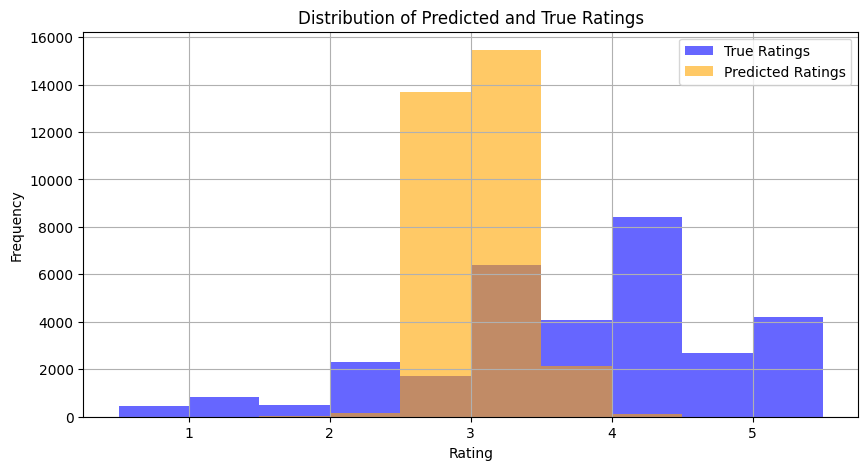

In [9]:
# Plot the distribution of the predictions and the true ratings
plt.figure(figsize=(10, 5))
plt.hist(actual_test_ratings, bins=np.arange(0.5, 6, 0.5), alpha=0.6, color='blue', label='True Ratings')
plt.hist(predicted_test_ratings, bins=np.arange(0.5, 6, 0.5), alpha=0.6, color='orange', label='Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted and True Ratings')
plt.legend()
plt.grid(True)
plt.show()

### NANs Replaced by 0s

In [11]:
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error

# Load datasets
ratings_train = np.load(os.path.join(data_dir, 'ratings_train.npy'))
ratings_test = np.load(os.path.join(data_dir, 'ratings_test.npy'))

# Replace NaN values in the training set with 0 (indicating absence of a rating)
ratings_train_filled_with_zeros = np.nan_to_num(ratings_train)

# Build a sparse matrix from the training data (with NaNs replaced by 0)
row_indices, col_indices = np.where(ratings_train_filled_with_zeros != 0)
data = ratings_train_filled_with_zeros[row_indices, col_indices]
train_sparse_matrix = coo_matrix((data, (row_indices, col_indices)), shape=ratings_train.shape)

# Initialize ALS model (you can tune the parameters as needed)
als_model = AlternatingLeastSquares(factors=40, regularization=1, iterations=30)

# Train the ALS model on the sparse matrix
als_model.fit(train_sparse_matrix)

# Get the user and item factors after training
user_factors = als_model.user_factors
item_factors = als_model.item_factors

# Generate the full predicted ratings matrix using the dot product of user and item factors
predicted_ratings = np.dot(user_factors, item_factors.T)

# Clip the predicted ratings to the range [0.5, 5]
predicted_ratings_clipped = np.clip(predicted_ratings, 0.5, 5)

# Fill in the missing values in the test set (i.e., where test set has NaN values)
filled_test_set = np.copy(ratings_test)
nan_mask = np.isnan(filled_test_set)
filled_test_set[nan_mask] = predicted_ratings_clipped[nan_mask]

# Extract non-NaN values from the test set and corresponding predictions
test_mask = ~np.isnan(ratings_test)
actual_test_ratings = ratings_test[test_mask]
predicted_test_ratings = predicted_ratings_clipped[test_mask]

# Calculate RMSE to compare predicted values with actual values in the test set
rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))
print(f"RMSE between predicted and actual test ratings: {rmse}")

# Calculate accuracy (percentage of exact matches)
exact_matches = np.sum(np.isclose(predicted_test_ratings, actual_test_ratings, atol=0.25))  # Allow small tolerance
total_ratings = len(actual_test_ratings)
accuracy = exact_matches / total_ratings * 100

print(f"Accuracy (exact matches): {accuracy:.2f}%")


/home/stathis/miniconda3/envs/AR3K/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0004425048828125 seconds
  warnings.warn(
100%|██████████| 30/30 [00:00<00:00, 46.19it/s]


RMSE between predicted and actual test ratings: 3.178783833310055
Accuracy (exact matches): 1.37%


In [1]:
# Plot the distribution of predicted ratings (clipped) against the actual ratings
plt.figure(figsize=(8, 6))
plt.scatter(actual_test_ratings, predicted_test_ratings, alpha=0.5, color='blue')
plt.plot([0.5, 5], [0.5, 5], color='red', linestyle='--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings (Clipped)')
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined